In [1]:
import stim
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

from pathlib import Path
import sys
sys.path.insert(0, Path.cwd().parent)
print(Path.cwd().parent)
# from src.GNN_Decoder import GNN_Decoder 
# from src.gnn_models import RecurrentGNN

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

c:\Users\isakb\Documents\M.Sc Physics\Code\GNN_decoder_quant


#### Setup

In [2]:
# code and noise settings
code_size = 5
p = 1e-3
reps = 10
n_samples = 8

# training settings
n_its = 1
batch_sz = 4
lr = 1e-3
loss = nn.BCEWithLogitsLoss()

# graph settings
n_node_features = 3

##### Run simulations

In [3]:
def syndrome_mask(code_size, reps=5):
    
    sz = code_size + 1
    
    syndrome_x = np.zeros((sz, sz), dtype=np.uint8)
    syndrome_x[::2, 1:sz - 1:2] = 1
    syndrome_x[1::2, 2::2] = 1
    
    syndrome_z = np.rot90(syndrome_x) * 3
    
    return np.dstack([syndrome_x + syndrome_z] * (reps +  1))

def stim_to_syndrome(stabilizer_changes, det_coords, code_grid):
    
    syndrome = np.zeros_like(code_grid)
    
    # stack stabilizer changes as first-to-last time step
    # note that detector coords represents the coordinates (x, y, t) of the measurement qubits
    syndrome[det_coords[:, 1], det_coords[:, 0], det_coords[:, 2]] = stabilizer_changes
    
    # we only care about differences in measurements
    syndrome[:, :, 1:] = (syndrome[:, :, 1:] - syndrome[:, :, 0:-1]) % 2
    
    # using our code_grid we can convert X/Z stabilizer measurements to 1:s and 3:s
    syndrome[np.nonzero(syndrome)] = code_grid[np.nonzero(syndrome)]
    
    return syndrome

In [4]:
circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=reps,
    distance=code_size,
    after_clifford_depolarization=p,
    after_reset_flip_probability=p,
    before_measure_flip_probability=p,
    before_round_data_depolarization=p,
)

# detection grid
det_coords = circuit.get_detector_coordinates()
det_coords = np.array(list(det_coords.values()))

# rescale space like coordinates:
det_coords[:, :2] = det_coords[:, :2] / 2
det_coords = det_coords.astype(np.uint8)

# sample data (need more shots since we sometimes only get identity)
n_shots = 12
sampler = circuit.compile_detector_sampler()
stim_data, observable_flips = sampler.sample(shots=n_shots, separate_observables=True)

# sums over the detectors to check if we have a parity change
shots_w_flips = np.sum(stim_data, axis=1) != 0

# save only data for measurements with non-empty syndromes
stabilizer_changes = stim_data[shots_w_flips, :]
flips = observable_flips[shots_w_flips].astype(np.uint8)

# make sure we got enough non-identity samples
assert stabilizer_changes.shape[0] > n_samples, "need more shots"
stabilizer_changes = stabilizer_changes[:n_samples, :]
flips = flips[:n_samples]

# create a mask that converts our stabilizer changes to a graph syndrome
m = syndrome_mask(code_size, reps)
syndrome = stim_to_syndrome(stabilizer_changes[0, :], det_coords, m)


##### Create graphs

In [5]:
def get_node_list_3D(syndrome):
    defect_indx = np.nonzero(syndrome)
    pass
    

##### Initialize network

In [79]:
import torch_geometric.nn as nn_g
from torch_geometric.utils import grid
from torch_geometric.data import Data

n_edges = 1
n_features = 5
out_dim = 32
n_nodes = [2**i for i in range(1, 10)]
graph_conv = nn_g.GraphConv(n_features, out_dim)

times = []
for n in n_nodes:
    x = torch.rand((n, n_features))
    edge_index, _ = grid(n, n_edges)
    edge_attr = torch.rand((edge_index.shape[1], 1))
    graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    graph_list = [graph] * 12
    loader = DataLoader(graph_list, batch_size=12)
    for data in loader:
          
        print(f"{n=}")
        print(f"{edge_index.shape[1]=}")
        t = %timeit -o -r 10 -n 1000 y = graph_conv(data.x, data.edge_index, data.edge_attr)
        times.append(t)


n=2
edge_index.shape[1]=4
222 µs ± 21 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
n=4
edge_index.shape[1]=10
227 µs ± 15.6 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
n=8
edge_index.shape[1]=22
226 µs ± 5.59 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
n=16
edge_index.shape[1]=46
251 µs ± 10.8 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
n=32
edge_index.shape[1]=94
280 µs ± 11.4 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
n=64
edge_index.shape[1]=190
444 µs ± 28.5 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
n=128
edge_index.shape[1]=382
639 µs ± 31.1 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
n=256
edge_index.shape[1]=766
846 µs ± 18.9 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
n=512
edge_index.shape[1]=1534
1.48 ms ± 123 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)


Text(0.5, 1.0, 'CPU time for GraphConv')

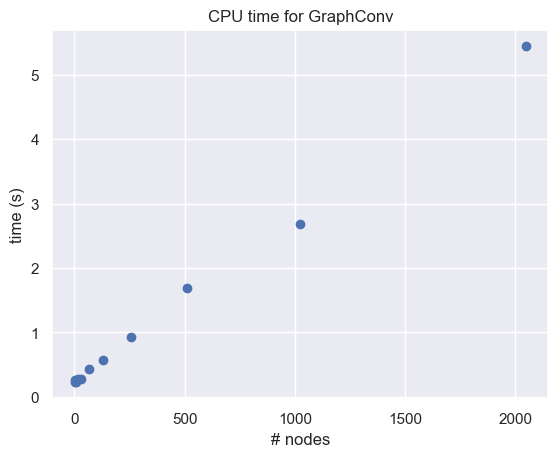

In [75]:
run_times = list(map(lambda x: np.mean(x.all_runs), times))

fig, ax = plt.subplots()
ax.plot(n_nodes, run_times, 'o')
ax.set_xlabel("# nodes")
ax.set_ylabel("time (s)")
ax.set_title("CPU time for GraphConv")

In [88]:
n = 10
x = torch.rand((n, n_features))
edge_index, _ = grid(n, n_edges)
edge_attr = torch.rand((edge_index.shape[1], 1))
graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
graph_list = [graph] * 12
loader = DataLoader(graph_list, batch_size=12)

batch = next(iter(loader))
dir(batch.edge_index)

['H',
 'T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__dlpack__',
 '__dlpack_device__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__idiv__',
 '__ifloordiv__',
 '__ilshift__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__long__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr_